In [1]:
#import system libs
import os
import time
import random
import pathlib
import itertools
from glob import glob
from tqdm import tqdm_notebook, tnrange

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.color import rgb2gray
from skimage.morphology import label
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow, concatenate_images


# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate , ReLU 

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

2025-08-20 20:06:45.057228: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755720405.250982      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755720405.306387      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules loaded


In [2]:
# function to create dataframe
def create_df(data_dir):
    images_paths = []
    masks_paths = glob(f'{data_dir}/*/*_mask*')

    for i in masks_paths:
        images_paths.append(i.replace('_mask', ''))

    df = pd.DataFrame(data= {'images_paths': images_paths, 'masks_paths': masks_paths})

    return df

# Function to split dataframe into train, valid, test
def split_df(df):
    # create train_df
    train_df, dummy_df = train_test_split(df, train_size= 0.8)

    # create valid_df and test_df
    valid_df, test_df = train_test_split(dummy_df, train_size= 0.5)

    return train_df, valid_df, test_df


In [3]:

# Optimized generator function
def create_gens_optimized(df, aug_dict, img_size=(256, 256), batch_size=32):
    # Reduced image size and batch size for better performance
    
    img_gen = ImageDataGenerator(rescale=1./255, **aug_dict)
    msk_gen = ImageDataGenerator(rescale=1./255, **aug_dict)

    # Create generators with preprocessing
    image_gen = img_gen.flow_from_dataframe(
        df, x_col='images_paths', class_mode=None, 
        color_mode='rgb', target_size=img_size,
        batch_size=batch_size, seed=1
    )

    mask_gen = msk_gen.flow_from_dataframe(
        df, x_col='masks_paths', class_mode=None, 
        color_mode='grayscale', target_size=img_size,
        batch_size=batch_size, seed=1
    )

    # Optimized generator - preprocessing moved to ImageDataGenerator
    gen = zip(image_gen, mask_gen)
    for (img, msk) in gen:
        # Simple thresholding - much faster
        msk = (msk > 0.5).astype(np.float32)
        yield (img, msk)

In [4]:
def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    # first encoder block
    x= Conv2D(filters =64 , kernel_size = (3,3) , strides = (1,1) , padding= 'same', kernel_initializer='he_normal')(inputs)
    x= ReLU()(x)
    x= Conv2D(filters =64 , kernel_size = (3,3) , strides = (1,1) , padding= 'same', kernel_initializer='he_normal')(x)
    x= ReLU()(x)
    skip1 =x
    x= MaxPooling2D(pool_size = (2,2))(x)
    

    # second encoder block

    x= Conv2D(filters =128 , kernel_size = (3,3) , strides = (1,1) , padding= 'same', kernel_initializer='he_normal')(x)
    x= ReLU()(x)
    x= Conv2D(filters =128 , kernel_size = (3,3) , strides = (1,1) , padding= 'same', kernel_initializer='he_normal')(x)
    x= ReLU()(x)
    skip2 =x
    x= MaxPooling2D(pool_size = (2,2))(x)


    # third encoder block

    x= Conv2D(filters =256 , kernel_size = (3,3) , strides = (1,1) , padding= 'same', kernel_initializer='he_normal')(x)
    x= ReLU()(x)
    x= Conv2D(filters =256 , kernel_size = (3,3) , strides = (1,1) , padding= 'same', kernel_initializer='he_normal')(x)
    x= ReLU()(x)
    x = Dropout(0.1)(x) 
    skip3 =x
    x= MaxPooling2D(pool_size = (2,2))(x)


    # forth encoder block

    x= Conv2D(filters =512 , kernel_size = (3,3) , strides = (1,1) , padding= 'same',kernel_initializer='he_normal')(x)
    x= ReLU()(x)
    x= Conv2D(filters =512 , kernel_size = (3,3) , strides = (1,1) , padding= 'same',kernel_initializer='he_normal')(x)
    x= ReLU()(x)
    x = Dropout(0.1)(x) 
    skip4 =x
    x= MaxPooling2D(pool_size = (2,2))(x)

    #bridge 

    x= Conv2D(filters =1024 , kernel_size = (3,3) , strides = (1,1) , padding= 'same',kernel_initializer='he_normal')(x)
    x= ReLU()(x)
    x= Conv2D(filters =1024 , kernel_size = (3,3) , strides = (1,1) , padding= 'same',kernel_initializer='he_normal')(x)
    x= ReLU()(x)
    x = Conv2DTranspose (512 , kernel_size = (3,3) ,strides = (2,2), padding = 'same' ,kernel_initializer='he_normal')(x)
    x= ReLU()(x)


    #first decoder block

    x= concatenate ([x  , skip4])
    x= Conv2D(filters =512 , kernel_size = (3,3) , strides = (1,1) , padding= 'same',kernel_initializer='he_normal')(x)
    x= ReLU()(x)
    x= Conv2D(filters =512 , kernel_size = (3,3) , strides = (1,1) , padding= 'same',kernel_initializer='he_normal')(x)
    x= ReLU()(x)
    x = Conv2DTranspose (256 , kernel_size = (3,3) ,strides = (2,2), padding = 'same' ,kernel_initializer='he_normal')(x)
    x= ReLU()(x)


    #second decoder block

    x= concatenate ([x  , skip3])
    x= Conv2D(filters =256 , kernel_size = (3,3) , strides = (1,1) , padding= 'same',kernel_initializer='he_normal')(x)
    x= ReLU()(x)
    x= Conv2D(filters =256 , kernel_size = (3,3) , strides = (1,1) , padding= 'same',kernel_initializer='he_normal')(x)
    x= ReLU()(x)
    x = Dropout(0.1)(x) 

    x= Conv2DTranspose (128 , kernel_size = (3,3) ,strides = (2,2), padding = 'same',kernel_initializer='he_normal' )(x)
    x= ReLU()(x)



    #third decoder block

    x= concatenate ([x  , skip2])
    x= Conv2D(filters =128 , kernel_size = (3,3) , strides = (1,1) , padding= 'same',kernel_initializer='he_normal')(x)
    x= ReLU()(x)
    x= Conv2D(filters =128 , kernel_size = (3,3) , strides = (1,1) , padding= 'same',kernel_initializer='he_normal')(x)
    x= ReLU()(x)
    x = Dropout(0.1)(x) 

    x = Conv2DTranspose (64 , kernel_size = (3,3) ,strides = (2,2), padding = 'same',kernel_initializer='he_normal' )(x)
    x= ReLU()(x)


    #forth decoder block

    x= concatenate ([x  , skip1])
    x= Conv2D(filters =64 , kernel_size = (3,3) , strides = (1,1) , padding= 'same',kernel_initializer='he_normal')(x)
    x= ReLU()(x)
    x= Conv2D(filters =64 , kernel_size = (3,3) , strides = (1,1) , padding= 'same',kernel_initializer='he_normal')(x)
    x= ReLU()(x)

    # final block
    x= Conv2D(filters =1 , kernel_size = (1,1) , activation = 'sigmoid',kernel_initializer='he_normal')(x)

    return Model(inputs=[inputs], outputs=[x])

    

In [5]:
def train_optimized():
    # Smaller image size and batch size
    img_size = (256, 256)  # Reduced from 256x256
    batch_size = 32        # Reduced from 40
    
    # Create optimized generators
    train_gen = create_gens_optimized(train_df, tr_aug_dict, img_size, batch_size)
    valid_gen = create_gens_optimized(valid_df, {}, img_size, batch_size)
    
    # Use lightweight model
    model = unet(input_size=(256, 256, 3))
    
    # Faster optimizer
    model.compile(
        optimizer=Adam(learning_rate=0.0001),  # Adam usually faster than Adamax
        loss=dice_loss, 
        metrics=['accuracy', iou_coef, dice_coef]
    )
    
    # Enhanced callbacks for efficiency
    callbacks = [
        ModelCheckpoint('unet.keras', save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    ]
    
    epochs = 100  # Start with fewer epochs
    
    # Calculate steps
    train_steps = len(train_df) // batch_size
    valid_steps = len(valid_df) // batch_size
    
    print(f"Training steps: {train_steps}, Validation steps: {valid_steps}")
    
    history = model.fit(
        train_gen,
        steps_per_epoch=train_steps,
        epochs=epochs,
        validation_data=valid_gen,
        validation_steps=valid_steps,
        callbacks=callbacks,
        verbose=1
    )
    
    return model, history


In [6]:
# function to create dice coefficient
def dice_coef(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

# function to create dice loss
def dice_loss(y_true, y_pred, smooth=100):
    return -dice_coef(y_true, y_pred, smooth)

# function to create iou coefficient
def iou_coef(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

In [7]:
def show_images(images, masks):
    plt.figure(figsize=(12, 12))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        img_path = images[i]
        mask_path = masks[i]
        # read image and convert it to RGB scale
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # read mask
        mask = cv2.imread(mask_path)
        # sho image and mask
        plt.imshow(image)
        plt.imshow(mask, alpha=0.4)

        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [8]:
def kaggle_optimizations():
    """
    Additional optimizations for Kaggle environment
    """
    # Enable GPU growth (if using TensorFlow)
    try:
        gpus = tf.config.experimental.list_physical_devices('GPU')
        if gpus:
            tf.config.experimental.set_memory_growth(gpus[0], True)
            print("GPU memory growth enabled")
    except:
        pass
    
    # Use mixed precision training for speed
    try:
        from tensorflow.keras.mixed_precision import experimental as mixed_precision
        policy = mixed_precision.Policy('mixed_float16')
        mixed_precision.set_policy(policy)
        print("Mixed precision training enabled")
    except:
        pass

In [9]:
data_dir = '/kaggle/input/lgg-mri-segmentation/kaggle_3m'

df = create_df(data_dir)
train_df, valid_df, test_df = split_df(df)



tr_aug_dict = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

kaggle_optimizations()
model, history = train_optimized()

GPU memory growth enabled


I0000 00:00:1755720419.325900      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Training steps: 98, Validation steps: 12
Found 3143 validated image filenames.
Found 3143 validated image filenames.
Epoch 1/100


I0000 00:00:1755720452.535522      98 service.cc:148] XLA service 0x7d3b14004180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755720452.536491      98 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1755720453.531357      98 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-08-20 20:07:40.141208: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=2} for conv (f32[32,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,128,128]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-08-20

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4989 - dice_coef: 0.0949 - iou_coef: 0.0574 - loss: -0.0949Found 393 validated image filenames.
Found 393 validated image filenames.

Epoch 1: val_loss improved from inf to -0.41354, saving model to unet.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 246s 2s/step - accuracy: 0.5013 - dice_coef: 0.0964 - iou_coef: 0.0584 - loss: -0.0964 - val_accuracy: 0.9914 - val_dice_coef: 0.4135 - val_iou_coef: 0.2699 - val_loss: -0.4135 - learning_rate: 1.0000e-04
Epoch 2/100


E0000 00:00:1755720691.920560      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755720692.153515      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755720692.768675      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755720693.024899      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 769ms/step - accuracy: 0.9903 - dice_coef: 0.4803 - iou_coef: 0.3334 - loss: -0.4948
Epoch 2: val_loss improved from -0.41354 to -0.67507, saving model to unet.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 100s 821ms/step - accuracy: 0.9903 - dice_coef: 0.4809 - iou_coef: 0.3340 - loss: -0.4954 - val_accuracy: 0.9938 - val_dice_coef: 0.6751 - val_iou_coef: 0.5163 - val_loss: -0.6751 - learning_rate: 1.0000e-04
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 766ms/step - accuracy: 0.9926 - dice_coef: 0.6367 - iou_coef: 0.4767 - loss: -0.6342

E0000 00:00:1755720867.353527      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755720867.587139      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755720868.263491      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755720868.520485      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 3: val_loss did not improve from -0.67507
98/98 ━━━━━━━━━━━━━━━━━━━━ 87s 884ms/step - accuracy: 0.9926 - dice_coef: 0.6365 - iou_coef: 0.4766 - loss: -0.6341 - val_accuracy: 0.9937 - val_dice_coef: 0.6599 - val_iou_coef: 0.4964 - val_loss: -0.6603 - learning_rate: 1.0000e-04
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 763ms/step - accuracy: 0.9936 - dice_coef: 0.6633 - iou_coef: 0.5080 - loss: -0.6568
Epoch 4: val_loss improved from -0.67507 to -0.71025, saving model to unet.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 80s 815ms/step - accuracy: 0.9936 - dice_coef: 0.6632 - iou_coef: 0.5078 - loss: -0.6567 - val_accuracy: 0.9929 - val_dice_coef: 0.7160 - val_iou_coef: 0.5613 - val_loss: -0.7103 - learning_rate: 1.0000e-04
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 763ms/step - accuracy: 0.9942 - dice_coef: 0.6384 - iou_coef: 0.4847 - loss: -0.6541
Epoch 5: val_loss did not improve from -0.71025
98/98 ━━━━━━━━━━━━━━━━━━━━ 78s 795ms/step - accuracy: 0.9942 - dice_coef: 0.6389 - iou_coef: 0.4851 

In [10]:
    """
    Properly evaluate the model using data generators
    """
    print("Creating evaluation generators...")
    img_size = (256 ,256)
    batch_size = 32
    # Create generators for evaluation (no augmentation)
    train_eval_gen = create_gens_optimized(train_df, {}, img_size, batch_size)
    valid_eval_gen = create_gens_optimized(valid_df, {}, img_size, batch_size)  
    test_eval_gen = create_gens_optimized(test_df, {}, img_size, batch_size)
    
    # Calculate steps for each dataset
    train_steps = len(train_df) // batch_size
    valid_steps = len(valid_df) // batch_size
    test_steps = len(test_df) // batch_size
    
    print(f"Train steps: {train_steps}")
    print(f"Valid steps: {valid_steps}")
    print(f"Test steps: {test_steps}")
    print("-" * 50)
    
    # Evaluate each dataset
    print("Evaluating on training set...")
    train_score = model.evaluate(train_eval_gen, steps=train_steps, verbose=1)
    
    print("Evaluating on validation set...")
    valid_score = model.evaluate(valid_eval_gen, steps=valid_steps, verbose=1)
    
    print("Evaluating on test set...")
    test_score = model.evaluate(test_eval_gen, steps=test_steps, verbose=1)
    
    # Print results
    print("\n" + "="*50)
    print("EVALUATION RESULTS")
    print("="*50)
    
    metric_names = model.metrics_names
    
    print("TRAIN SET:")
    for i, metric in enumerate(metric_names):
        print(f"  {metric}: {train_score[i]:.4f}")
    
    print("\nVALIDATION SET:")
    for i, metric in enumerate(metric_names):
        print(f"  {metric}: {valid_score[i]:.4f}")
    
    print("\nTEST SET:")
    for i, metric in enumerate(metric_names):
        print(f"  {metric}: {test_score[i]:.4f}")
    


Creating evaluation generators...
Train steps: 98
Valid steps: 12
Test steps: 12
--------------------------------------------------
Evaluating on training set...
Found 3143 validated image filenames.
Found 3143 validated image filenames.
98/98 ━━━━━━━━━━━━━━━━━━━━ 26s 268ms/step - accuracy: 0.9984 - dice_coef: 0.9197 - iou_coef: 0.8524 - loss: -0.9197
Evaluating on validation set...
Found 393 validated image filenames.
Found 393 validated image filenames.
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 282ms/step - accuracy: 0.9978 - dice_coef: 0.8915 - iou_coef: 0.8059 - loss: -0.8915
Evaluating on test set...
Found 393 validated image filenames.
Found 393 validated image filenames.
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 719ms/step - accuracy: 0.9982 - dice_coef: 0.9225 - iou_coef: 0.8570 - loss: -0.9225

EVALUATION RESULTS
TRAIN SET:
  loss: -0.9232
  compile_metrics: 0.9985

VALIDATION SET:
  loss: -0.9001
  compile_metrics: 0.9979

TEST SET:
  loss: -0.9111
  compile_metrics: 0.9980


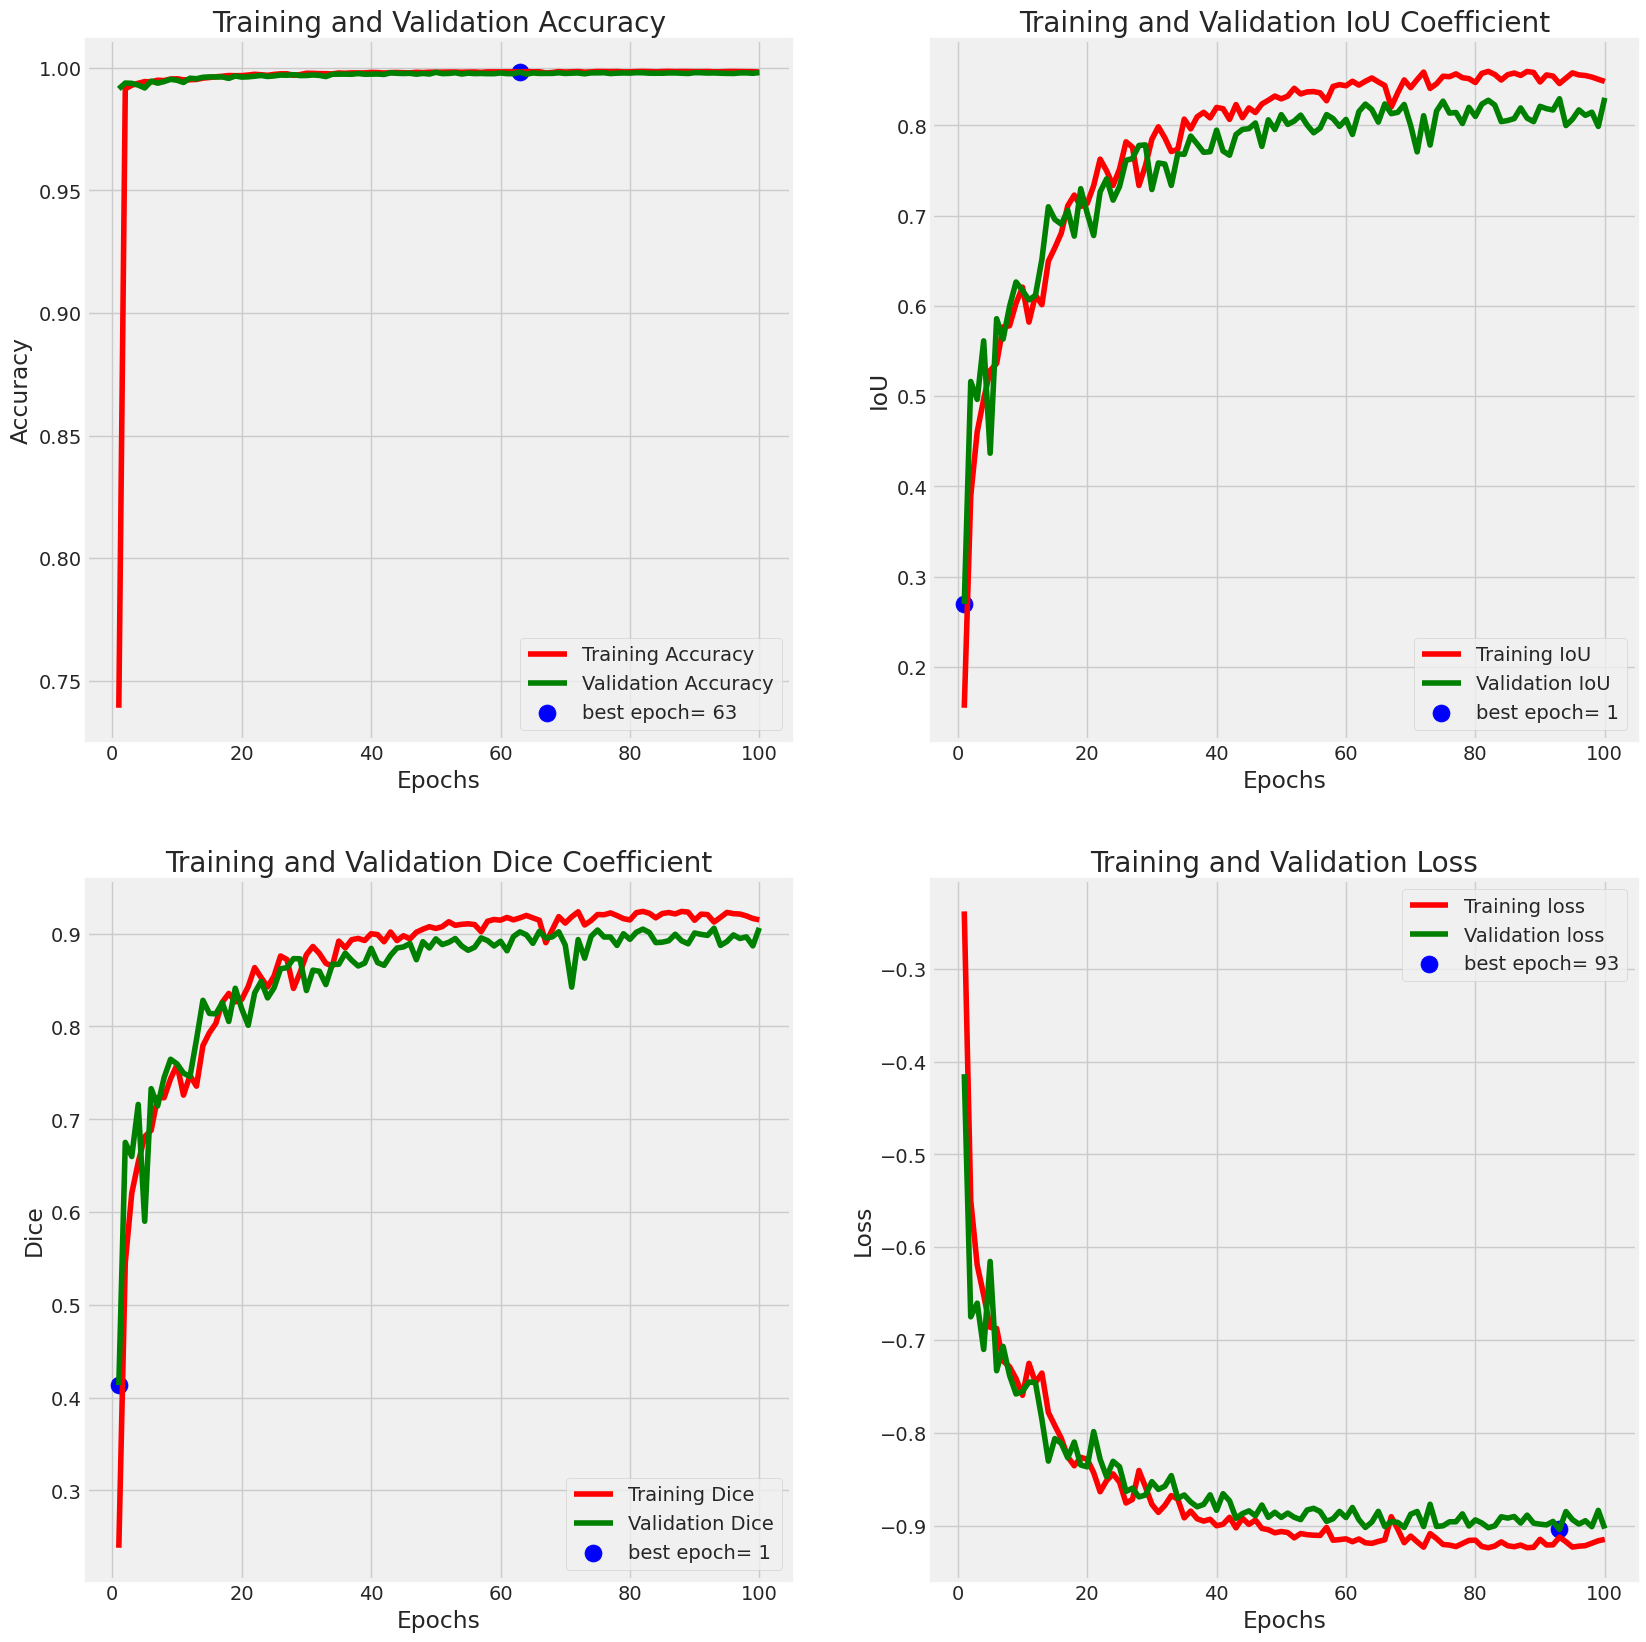

In [17]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_iou = hist.history['iou_coef']
    tr_dice = hist.history['dice_coef']
    tr_loss = hist.history['loss']

    val_acc = hist.history['val_accuracy']
    val_iou = hist.history['val_iou_coef']
    val_dice = hist.history['val_dice_coef']
    val_loss = hist.history['val_loss']

    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    index_iou = np.argmax(iou_coef)
    iou_highest = val_iou[index_iou]
    index_dice = np.argmax(dice_coef)
    dice_highest = val_dice[index_dice]
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]

    Epochs = [i+1 for i in range(len(tr_acc))]

    acc_label = f'best epoch= {str(index_acc + 1)}'
    iou_label = f'best epoch= {str(index_iou + 1)}'
    dice_label = f'best epoch= {str(index_dice + 1)}'
    loss_label = f'best epoch= {str(index_loss + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 20))
    plt.style.use('fivethirtyeight')

    # Training Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Training IoU
    plt.subplot(2, 2, 2)
    plt.plot(Epochs, tr_iou, 'r', label= 'Training IoU')
    plt.plot(Epochs, val_iou, 'g', label= 'Validation IoU')
    plt.scatter(index_iou + 1 , iou_highest, s= 150, c= 'blue', label= iou_label)
    plt.title('Training and Validation IoU Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    # Training Dice
    plt.subplot(2, 2, 3)
    plt.plot(Epochs, tr_dice, 'r', label= 'Training Dice')
    plt.plot(Epochs, val_dice, 'g', label= 'Validation Dice')
    plt.scatter(index_dice + 1 , dice_highest, s= 150, c= 'blue', label= dice_label)
    plt.title('Training and Validation Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice')
    plt.legend()

    # Training Loss
    plt.subplot(2, 2, 4)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout
    plt.show()

plot_training(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


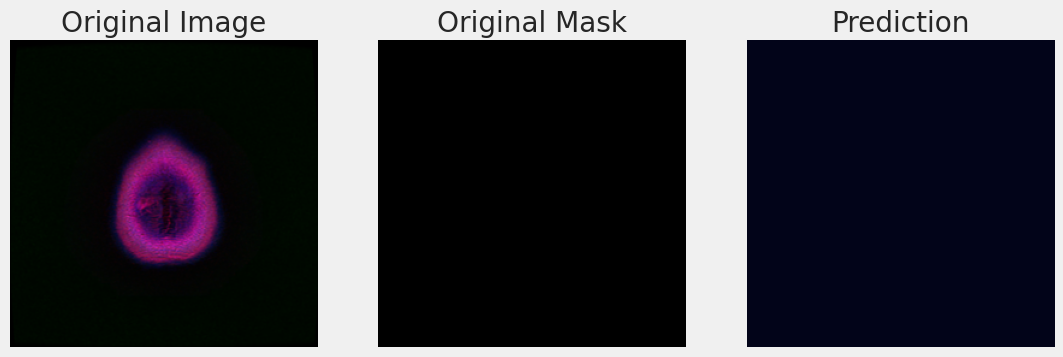

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


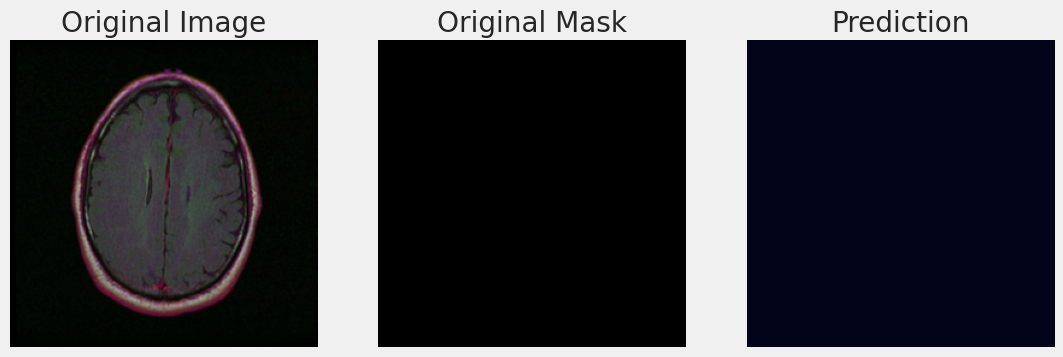

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


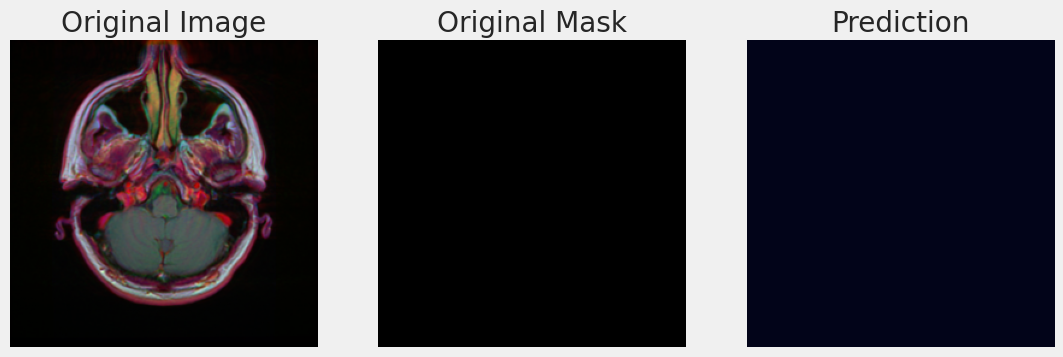

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


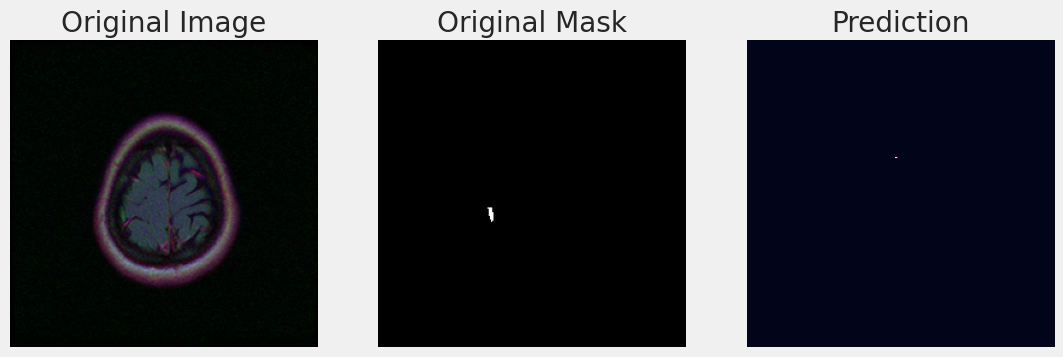

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


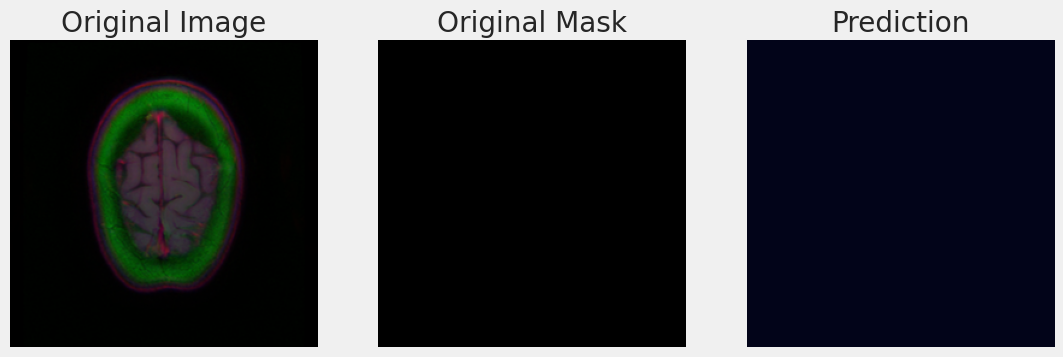

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


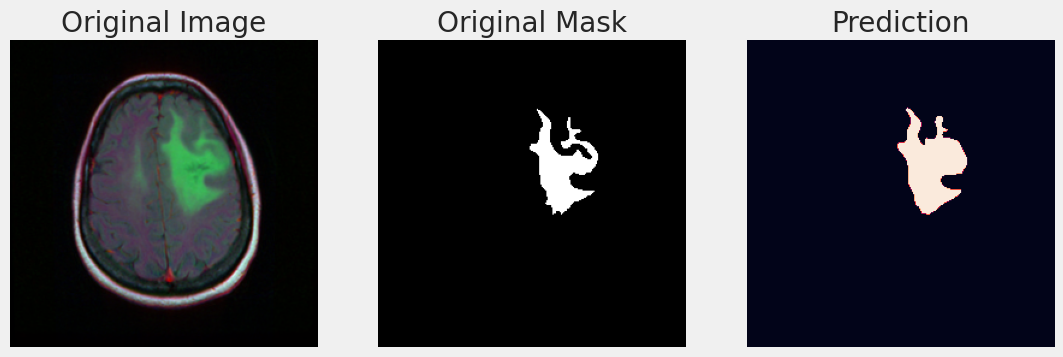

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


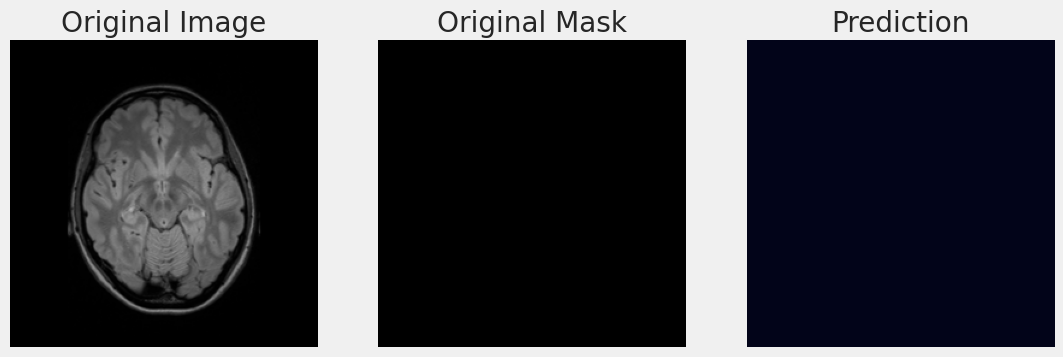

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


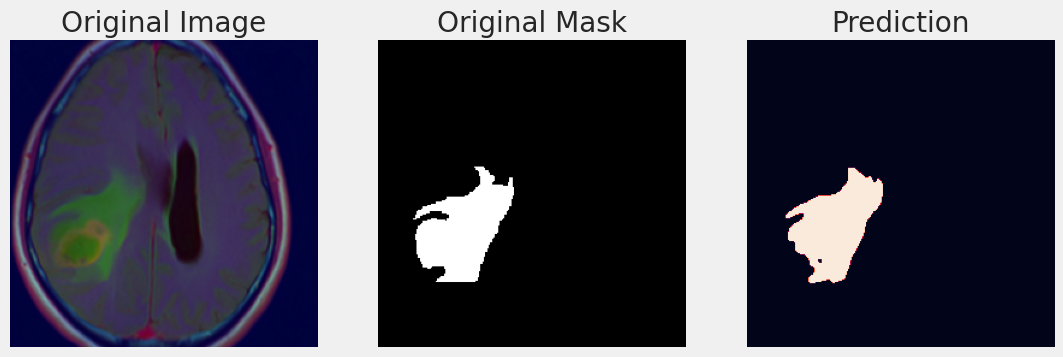

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


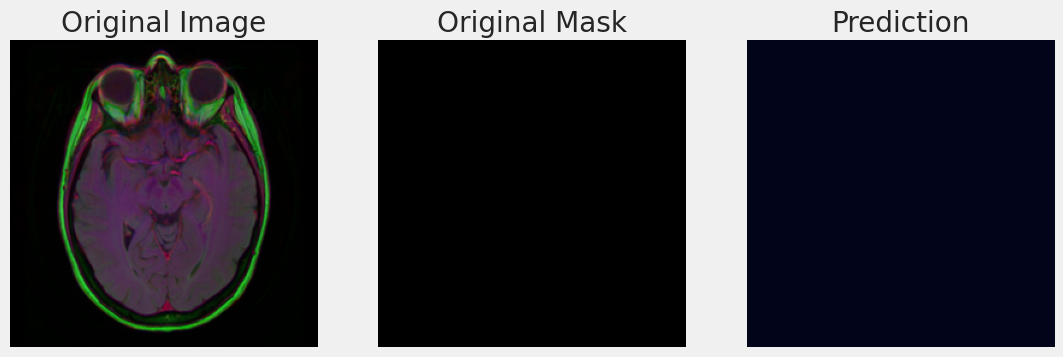

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


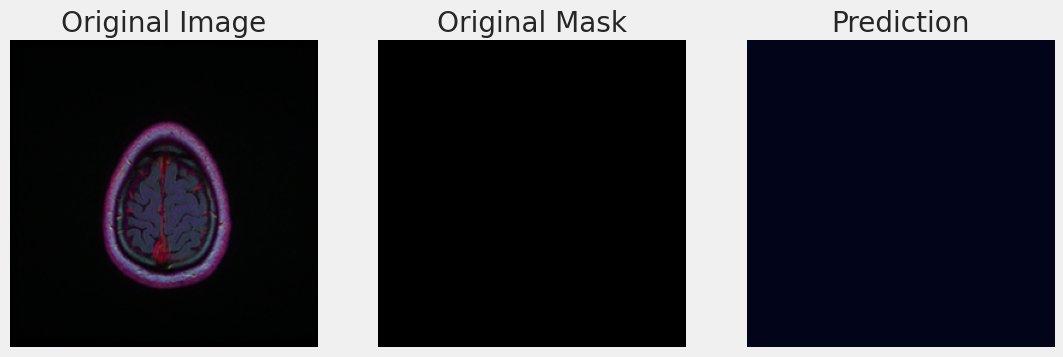

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


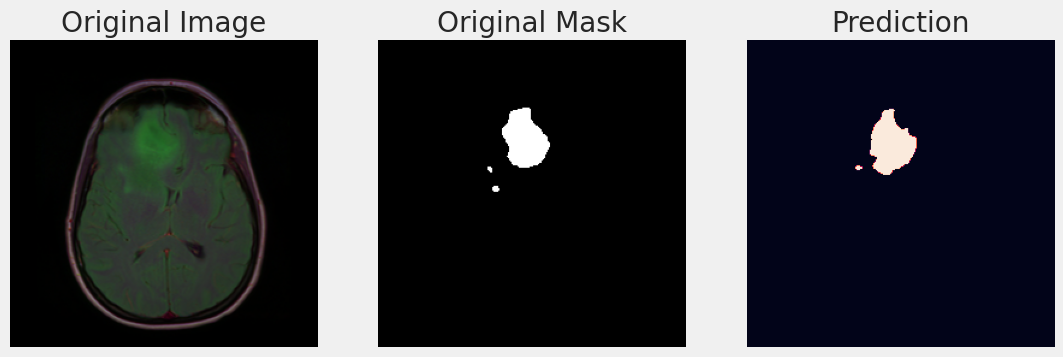

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


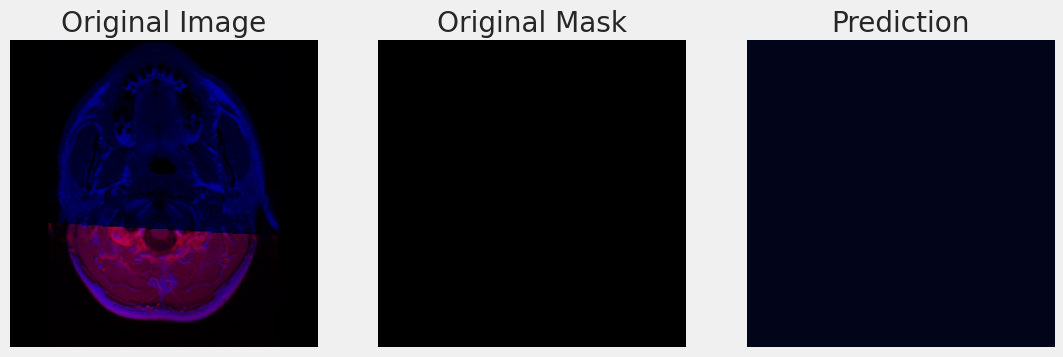

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


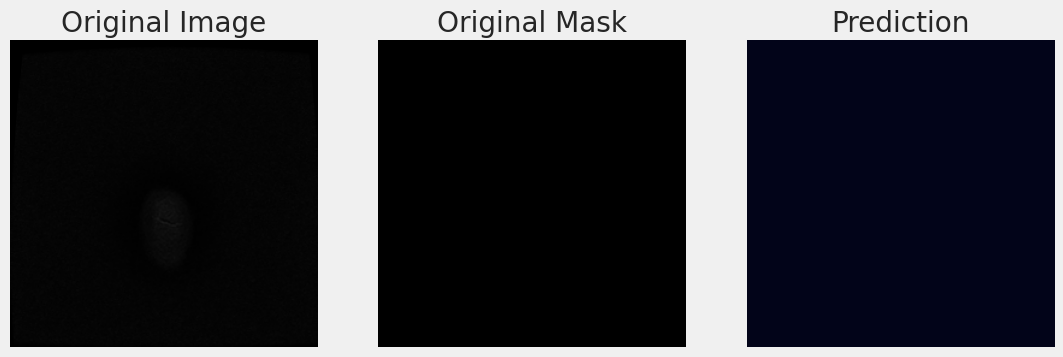

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


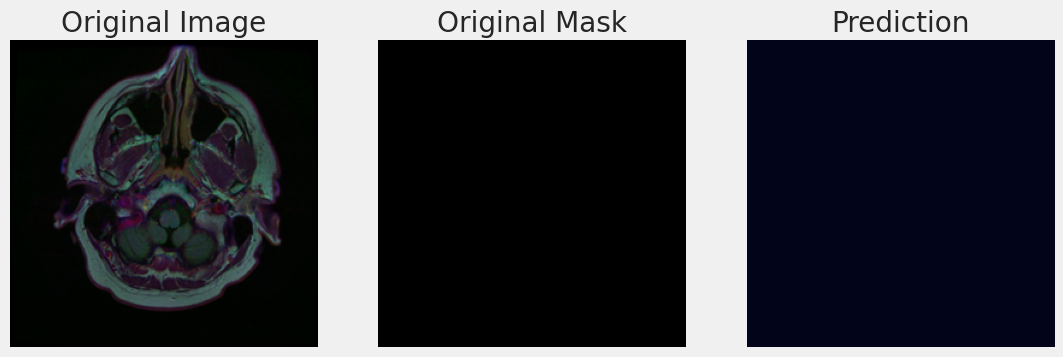

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


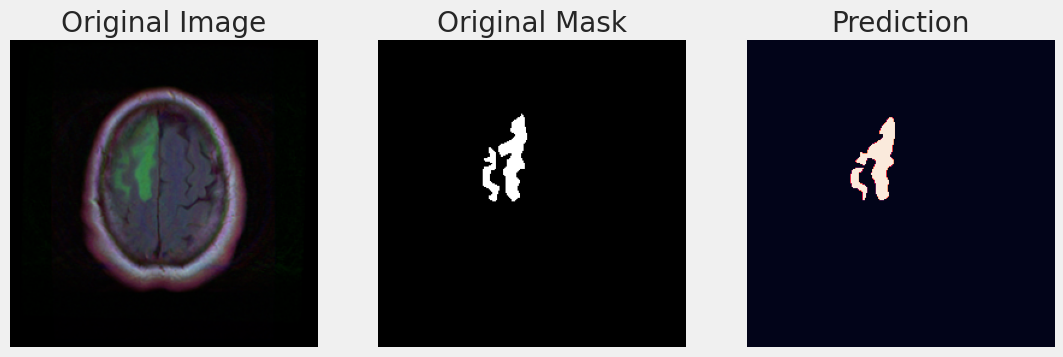

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


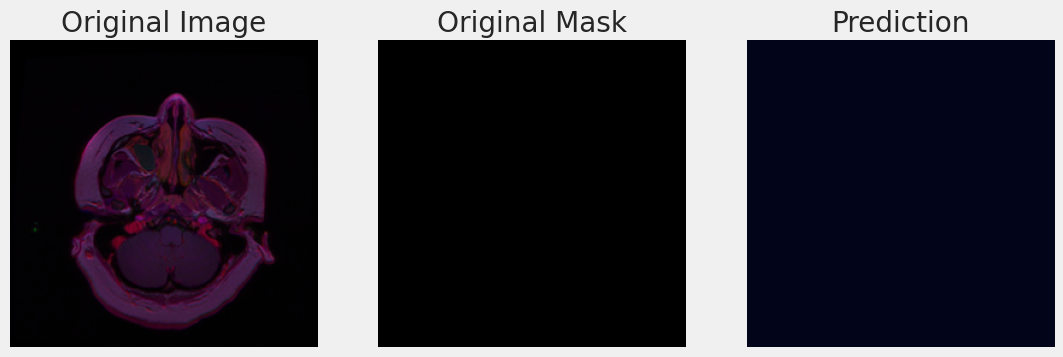

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


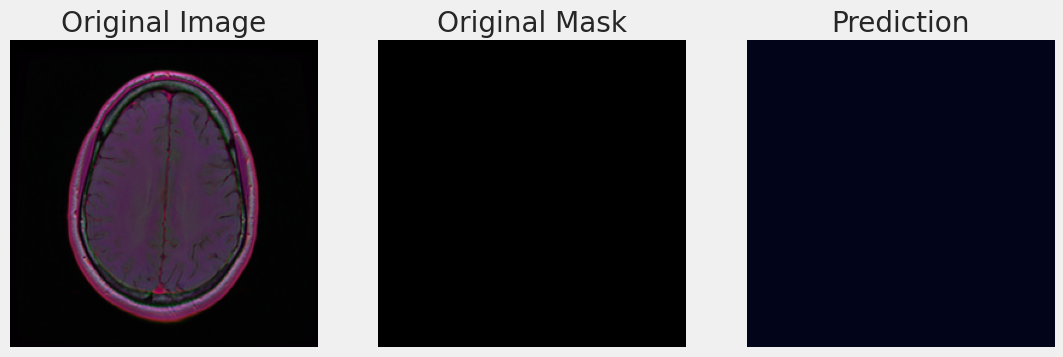

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


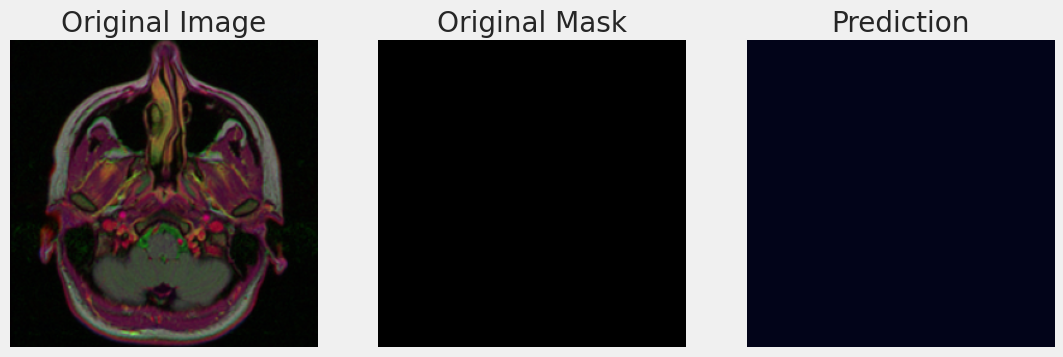

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


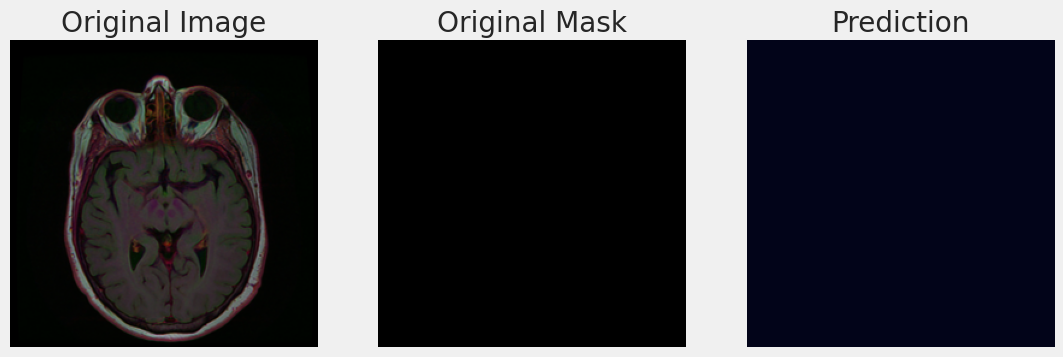

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


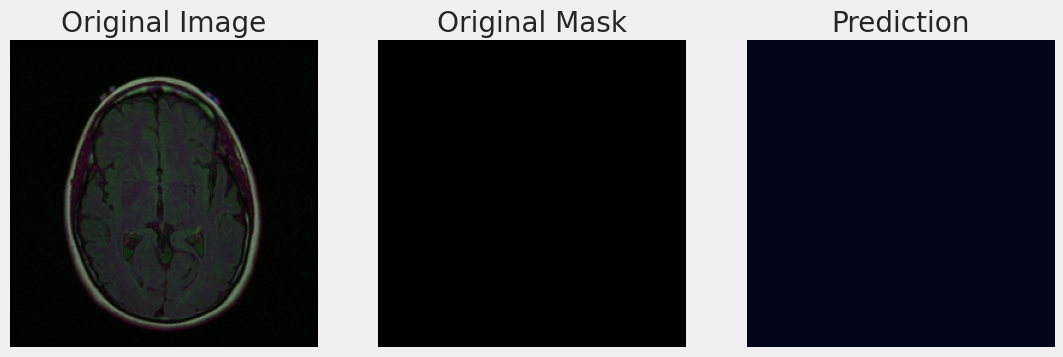

In [18]:
for _ in range(20):
    index = np.random.randint(1, len(test_df.index))
    img = cv2.imread(test_df['images_paths'].iloc[index])
    img = cv2.resize(img, (256, 256))
    img = img/255
    img = img[np.newaxis, :, :, : ]

    predicted_img = model.predict(img)

    plt.figure(figsize=(12, 12))
    
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(test_df['masks_paths'].iloc[index])))
    plt.axis('off')
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.axis('off')
    
    plt.show()
